# IBM Advanced Data Science Capstone
## Data Cleaning and Feature Engineering
Data cleaning is the process of ensuring that the data is as decontaminated as possible. This can be done by either modifying data that is incorrect or irrelevant, or by simply remove them, as contaminated data can force the machine learning model to learn on observations that are wrong, which in turn will make future predictions be affected by this learning. It is therefore important to eliminate as many errors as possible. In what follows, outliers will be recalculated or removed, missing values will be imputed where applicable, while wrong values will be corrected where possible.

Feature engineering is the process of transforming data into something the various machine learning algorithms can process. As an example, categorical features needs to be converted into something numerical (what is the average of Tesla and Volkswagen? It doesn't make sense), or very skewed data could have need of being transformed into somthing that more closely resembles a normal distribution of data. Furthermore, feature engineering also consists of extracting further information from the variables at hand.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime
import re
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_parquet('data/vehicles_etl.parquet.gzip')

### Model
The model of a vehicle is very important when determining the sales price. It has a big say wether it is a Ford Fiesta or a Ford Mustang, so keeping this feature is crucial. We were able to reduce the amount of different `model` values in the previous notebook, but we are still left with models, that only accounts for a single observation. In fact, in order to have some meaningful information in the model, we should focus only on the models that occurs more than ten times in the data.

In [3]:
data['model'].value_counts()

f-150                     10104
silverado                  9800
f-250                      4973
sierra                     4481
escape                     4239
                          ...  
covered wagon trailers        1
range                         1
m235i                         1
650i / b6                     1
allure                        1
Name: model, Length: 951, dtype: int64

By ridding ourselves of these observations, we note that we lose less than half a percent of the data.

In [4]:
n = 10
print(
    f"Number of models occuring less than {n} times: {(data['model'].value_counts() < n).sum()}",
    f"This accounts for {data.groupby(['manufacturer', 'model']).filter(lambda x: len(x) < n).shape[0]/data.shape[0]*100:.2f}% of the dataset",
    sep='\n'
)

Number of models occuring less than 10 times: 334
This accounts for 0.38% of the dataset


Now, we can try and redistribute these observation onto the `model` column, but since this accounts for less than 1% of the entire dataset, we'll simply drop the rows.

In [5]:
data = data \
    .groupby(['manufacturer', 'model']) \
    .filter(lambda x: len(x) >= n)

data['model'].value_counts()

f-150               10096
silverado            9800
f-250                4971
sierra               4473
escape               4239
                    ...  
sl                     10
g-series               10
scion iq               10
cooper s hardtop       10
cascada                10
Name: model, Length: 617, dtype: int64

We're left with a more manageable amount of unique models.

### Location and Distance
Let's now look at the newly created `distance` columns, as we can see from a data summary, that some of the values are quite large.

In [6]:
data['distance_0'].describe()

count    253340.000000
mean        249.439531
std         364.708781
min           0.015682
25%          73.070752
50%         168.486908
75%         301.114559
max       15903.621465
Name: distance_0, dtype: float64

The `distance_0` column have some very extreme values. Calculating the distance from the latitude/longitude points of the dataset to the capital of the state, as indicated in the same data, we find distances of over 15,000 km. Consider Alaska. This is the largest state by landmass in the US at 1,723,337 km$^2$. If we for simplicity assume the state to be a square, that the capital is at the center, and using the Pythagorean theorem, we find the maximum distance within a state to it's capital to be
$$d = \sqrt{\sqrt{1723337\text{km}}^2 + \sqrt{1723337\text{km}}^2} \approx 1856\text{km}$$
If we make a scatter plot of the latitudes and longitudes and grouping by state, we can also see some coordinates in places they shouldn't be (some are even in the ocean):

In [7]:
fig = px.scatter_mapbox(
    data[data['distance_0'] >= 1000],
    lat='lat',
    lon='long',
    color='state',
    zoom=2.8,
    height=600,
    width=800
)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'t':0, 'l':0, 'b':0})
fig.show()

There are a couple of possibilities of handling these outliers. Either we remove them completely, or we calculate a threshold for each state and cap all values higher with the threshold value. In the following, the threshold is calculated by finding the distance between each capital, and averaging the distances of the smallest three. We calculated the averange in the ETL section. Below we will cap the values:

In [8]:
dist_cols = [col for col in data.columns.values if (col[:8] == 'distance') & (col != 'distance')]
for distance in dist_cols:
    data[distance].values[data[distance] > data['distance']] = data['distance'].values[data[distance] > data['distance']]

Following up on the neighboring distances, it is clear from below, that the amount of missing values increases as the neighboring state number goes up. This of course makes sense, since only very few states has eight neighboring states. From `distance_4` and up the amount of missing values vs non-missing values is over 30%, so we'll drop those completely. We also have no more use of the `lat`, `long`, and `distance` columns, so we will remove those as well.

In [9]:
(data[dist_cols].isna().sum()/data.shape[0]).sort_values(ascending=False)

distance_8    0.959481
distance_7    0.946577
distance_6    0.776825
distance_5    0.618114
distance_4    0.356290
distance_3    0.152242
distance_2    0.030477
distance_1    0.023773
distance_0    0.006673
dtype: float64

In [10]:
data = data.drop(sorted(dist_cols)[3:] + ['lat', 'long'], axis=1)
data.describe()

,price,year,cylinders,odometer,distance_0,distance_1,distance_2,distance,popularity,fame,displacementcc,displacementci,displacementl,enginekw,enginehp,enginecylinders,doors,vin_avg_weight
count,255042.000000,255031.000000,156525.000000,2.196880e+05,253340.000000,248979.000000,247269.000000,255042.000000,252490.000000,252490.000000,254547.000000,254547.000000,254547.000000,246598.000000,250378.000000,254545.000000,254799.000000,254819.000000
mean,15725.872648,2011.034925,5.808414,9.898568e+04,195.766845,337.354899,332.693699,404.004814,58.318179,96.824480,3620.037825,221.172757,3.625115,180.637681,241.682876,5.734317,3.879587,1.761560
std,11876.933537,7.185739,1.606999,1.071574e+05,167.078607,151.398756,159.491906,333.282534,6.240503,2.094582,3946.592577,241.251264,3.953417,62.824099,83.748419,1.573921,0.678232,0.946218
min,2000.000000,1933.000000,3.000000,0.000000e+00,0.015682,0.154056,1.181180,93.065856,36.000000,77.000000,0.000000,0.000000,0.000000,6.711300,9.000000,1.000000,2.000000,1.000000
25%,6995.000000,2008.000000,4.000000,4.620475e+04,73.070752,219.627042,186.860449,248.408379,53.000000,96.000000,2362.000000,145.371987,2.400000,129.751800,175.000000,4.000000,4.000000,1.000000
50%,12595.000000,2012.000000,6.000000,9.300000e+04,159.284834,336.380732,320.122527,363.896262,59.000000,98.000000,3474.057568,212.000000,3.480769,171.848470,229.314737,6.000000,4.000000,1.000000
75%,20500.000000,2016.000000,8.000000,1.372848e+05,281.131867,432.790739,423.478344,502.232680,62.000000,98.000000,4600.000000,280.709223,4.600000,225.586073,302.515855,7.055556,4.000000,3.000000
max,78900.000000,2021.000000,12.000000,9.999999e+06,4064.895984,786.572870,786.572870,4064.895984,67.000000,98.000000,200000.000000,12204.748819,200.000000,594.322900,797.000000,12.000000,6.000000,3.000000


Finally, let's fill out the missing values in `distance_n` with the median distance in each state. If this is not possible, we'll proceed to fill out with the medians of n - 1.

In [11]:
data[dist_cols[:3]] = data \
    .groupby('state')[dist_cols[:3]] \
    .transform(lambda x: x.fillna(x.median()))

dist_cols = ['distance'] + dist_cols[:3]
for i in range(1, len(dist_cols)):
    data[dist_cols[i]] = data[dist_cols[i]].fillna(data.groupby('state')[dist_cols[i-1]].transform('median'))

The `state` and `capital` columns contains the same information. We'll drop one of them.

In [12]:
print(f"Rows where capital is different from state: {data[(data['state'] != data['capital'])].shape[0]}")
data = data.drop('capital', axis=1)

Rows where capital is different from state: 0


### Electric Cars
Before moving on, let's have a look at electric cars. Looking at Tesla, which only produce electrics, we see that multiple entries are listed with a fuel type of gas. This might be an issue with other cars as well. Let's try and fix this by scraping the [Wikipedia page of currently available electric cars](https://en.wikipedia.org/wiki/List_of_electric_cars_currently_available) and applying it to the dataset.

In [13]:
data.loc[data['manufacturer'] == 'tesla', 'fuel'].value_counts()

electric    175
gas          60
other         3
hybrid        1
Name: fuel, dtype: int64

In [14]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

CHROME_PATH = 'C:\Program Files%s\Google\Chrome\Application\chrome.exe'
CHROMEDRIVER_PATH = 'chromedriver\chromedriver.exe'

# Set some options (don't open the actual browser)
chrome_options = Options()
chrome_options.add_argument('--headless')

try:
    chrome_options.binary_location = CHROME_PATH % ''
    driver = webdriver.Chrome(
        executable_path=CHROMEDRIVER_PATH,
        chrome_options=chrome_options
    )
except:
    chrome_options.binary_location = CHROME_PATH % ' (x86)'
    driver = webdriver.Chrome(
        executable_path=CHROMEDRIVER_PATH,
        chrome_options=chrome_options
    )

# Scrape Wikipedia
driver.get('https://en.wikipedia.org/wiki/List_of_electric_cars_currently_available')
soup = BeautifulSoup(driver.page_source)
driver.close()

# Traverse the soup to get manufacturer and model
electric_cars = pd.DataFrame()
rows = soup.find_all('table', attrs={'class': 'wikitable sortable'})[0].find_all('tr')
for r in rows:
    if len(r.find_all('a')) > 0:
        electric_cars = electric_cars.append(
            pd.DataFrame([[r.find_all('td')[0].text.replace('\n', '').lower(), r.find_all('td')[1].text.replace('\n', '').lower()]],
            columns=['manufacturer', 'model'])
        )

# Remove redundancy in model column
electric_cars['model'] = electric_cars \
    .apply(lambda x: x['model'].replace(x['manufacturer'], ''), axis=1)
# Remove special characters from manufacturer
electric_cars['manufacturer'] = electric_cars['manufacturer'] \
    .apply(lambda x: re.sub(r'[^0-9a-z\-\s]', '', x))
# Fix "outliers" on Renault and Jaguar
data.loc[data['manufacturer'] == 'renault  renault samsung', 'manufacturer'] = 'renault'
data.loc[data['manufacturer'] == 'jaguar land rover', 'manufacturer'] = 'jaguar'
electric_cars = electric_cars.drop_duplicates()

In [15]:
data.loc[(data['model'].isin(electric_cars['model'])), 'fuel'] = 'electric'

### Engine Details
The `enginecylinders` column contains averages from the ETL notebook. This gives decimal cylinders, which doesn't really make sense, as well as eg. 7 cylinder motors, which doesn't exist. Looking at the unique values of the `cylinders` column, we are dealing with 3, 4, 5, 6, 8, 10, and 12 cylinder engines, so let's formulate a function, that rounds `enginecylinders` in this fashion: Let it round to nearest integer, if `enginecylinders` is less than or equal to 6, and to nearest 2 if `enginecylinders` is larger than 6.

In [16]:
def roundup_cylinders(x):
    if x <= 6:
        return np.round(x)
    else:
        return 2*np.round(x / 2)

In [17]:
data['enginecylinders'] = data['enginecylinders'].apply(roundup_cylinders)
data['cylinders'] = data['cylinders'].apply(roundup_cylinders)

In [18]:
data[['cylinders', 'enginecylinders']].isna().sum()

cylinders          98517
enginecylinders      497
dtype: int64

The engines of electric cars have no cylinders, so we set these to 0.

In [19]:
data.loc[data['fuel'] == 'electric', 'enginecylinders'] = 0

Using the data from National Highway Traffic Saftety Administration, we effectively fill out the `cylinders` column in over 100,000 instances. Let's keep the `enginecylinders` column and drop the other.

In [20]:
data = data.drop('cylinders', axis=1)

Looking at the data, occasionally the load from National Highway Traffic Saftety Administration isn't labelled correctly. As an example, a few of the cars have displacement in L listed in the `displacementcc` column. It is very few, but the more data the better. Since a displacement measured in cubic centimetres below 50 is rare, we'll focus on those observations:

In [21]:
data[data['displacementcc'] < 50].head()

,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,drive,size,...,engineconfiguration,model,displacementcc,displacementci,displacementl,enginekw,enginehp,enginecylinders,doors,vin_avg_weight
1115,5000,1995.0,honda,excellent,gas,NaN,clean,manual,fwd,compact,...,None,civic,1.5,0.091536,0.0015,112.021569,150.223373,4.0,4.0,3.0
14295,2600,1995.0,honda,None,gas,241000.0,clean,manual,None,None,...,None,civic,1.5,0.091536,0.0015,112.021569,150.223373,4.0,4.0,3.0
20844,13990,2014.0,bmw,good,electric,38276.0,clean,other,rwd,None,...,None,i3,0.0,0.000000,0.0000,126.769000,170.000000,0.0,4.0,1.0
21254,2990,1995.0,honda,None,None,202500.0,clean,automatic,None,None,...,None,civic,1.5,0.091536,0.0015,112.021569,150.223373,4.0,4.0,1.0
28543,2500,1995.0,honda,good,gas,NaN,clean,automatic,fwd,compact,...,None,civic,1.5,0.091536,0.0015,112.021569,150.223373,4.0,4.0,3.0


In [22]:
data['displacementl'].values[data['displacementcc'] < 50] = data['displacementcc'].values[data['displacementcc'] < 50]

A displacement other than 0 for electric vehicles is also not possible, so we'll reset those above to zero:

In [23]:
data[data['fuel'] == 'electric'].head()

,price,year,manufacturer,condition,fuel,odometer,title_status,transmission,drive,size,...,engineconfiguration,model,displacementcc,displacementci,displacementl,enginekw,enginehp,enginecylinders,doors,vin_avg_weight
42,9885,2012.0,subaru,excellent,electric,82000.0,clean,automatic,4wd,mid-size,...,horizontally opposed (boxer),forester,2500.000000,152.559360,2.500000,131.472646,176.307692,0.0,4.0,1.0
543,12991,2016.0,volkswagen,None,electric,31322.0,clean,other,fwd,None,...,None,golf,1800.000000,109.842739,1.800000,85.755500,115.000000,0.0,4.0,1.0
683,20000,2017.0,chevrolet,None,electric,25739.0,clean,automatic,fwd,None,...,None,bolt ev,3929.845274,239.813018,3.929859,149.140000,200.000000,0.0,4.0,1.0
1253,19999,2017.0,chevrolet,None,electric,21044.0,clean,automatic,fwd,None,...,None,bolt ev,3929.845274,239.813018,3.929859,149.140000,200.000000,0.0,4.0,1.0
1283,11999,2013.0,chevrolet,None,electric,78648.0,clean,automatic,fwd,None,...,None,volt,1400.000000,85.433242,1.400000,133.964886,179.649840,0.0,4.0,1.0


In [24]:
for col in ['displacementcc', 'displacementci', 'displacementl']:
    data.loc[data['fuel']=='electric', col] = 0.0

For the final cars, where fuel type is different from electric, but listed with 0 displacement, we simply remove the rows as the row count is very low and won't affect the model training much anyways.

In [25]:
print(f'Rows before: {data.shape[0]}')
data = data[~((data['fuel'] != 'electric') & (data['displacementl'] == 0))]
print(f'Rows after: {data.shape[0]}')

Rows before: 255042
Rows after: 255042


The `enginekw` should be roughly the same as `enginehp`/1.34, so we'll keep the one that has fewest missing values. From below, that column is `enginehp`:

In [26]:
data[['enginekw', 'enginehp']].isna().sum()

enginekw    8444
enginehp    4664
dtype: int64

In [27]:
data = data.drop('enginekw', axis=1)

Similarly for cylinders, a specific engine configuration does not apply for electric cars. Let's set it to "None".

In [28]:
data.loc[data['fuel'] == 'electric', 'engineconfiguration'] = 'None'

Let's fill the missing values with the median grouped by `manufacturer` and `model`. If that is not possible, we'll try with `manufacturer` only. And if we still have missing values, we'll apply the median over the entire dataset, grouped by `size`.

In [29]:
def fillna_median(input_data, column):
    # Try grouping by manufacturer and model and fill with median value
    input_data[column] = input_data \
        .groupby(['manufacturer', 'model'])[column] \
        .transform(lambda x: x.fillna(x.median()))

    # Try only with manufacturer for rows not hit by the above
    input_data[column] = input_data \
        .groupby(['manufacturer'])[column] \
        .transform(lambda x: x.fillna(x.median()))

    # Fill rest of missings with median over entire dataset
    input_data[column] = input_data[column] \
        .transform(lambda x: x.fillna(x.median()))

    return input_data[column]

In [30]:
data['enginehp'] = fillna_median(input_data=data, column='enginehp')

In [31]:
data[['enginehp', 'displacementl']].corr()

,enginehp,displacementl
enginehp,1.000000,0.247539
displacementl,0.247539,1.000000


The displacement features should also be a conversion of eachother. If we make a correlation matrix of these features, we also see they are highly correlated. As all three have the same amount of missing observations, we'll just keep one of them.

In [32]:
data[['displacementcc', 'displacementci', 'displacementl']].corr()

,displacementcc,displacementci,displacementl
displacementcc,1.000000,0.997969,0.997957
displacementci,0.997969,1.000000,0.999989
displacementl,0.997957,0.999989,1.000000


In [33]:
data[['displacementcc', 'displacementci', 'displacementl']].isna().sum()

displacementcc    255
displacementci    255
displacementl     255
dtype: int64

In [34]:
data = data.drop(['displacementcc', 'displacementci'], axis=1)

We'll fill out the missing values of `displacementl` the same way as we did with `enginehp` above. Likewise with `odometer`.

In [35]:
data['displacementl'] = fillna_median(input_data=data, column='displacementl')
data['odometer'] = fillna_median(input_data=data, column='odometer')

### Condition
Let's look at the distribution of the `condition` column over `year` and `odometer`:

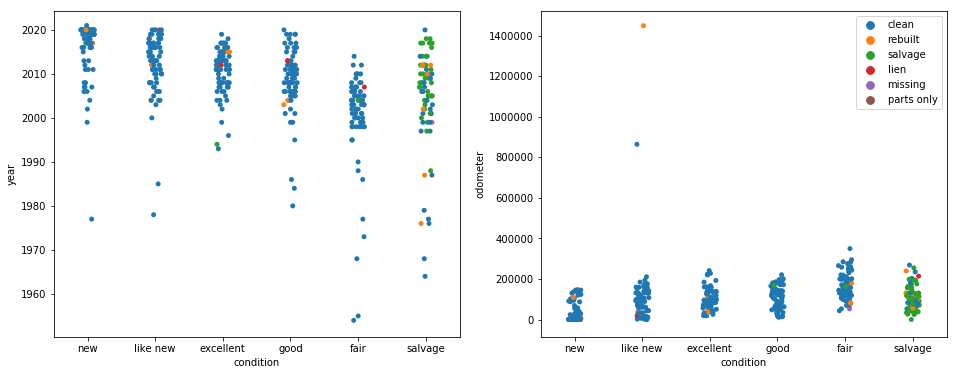

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i, col in enumerate(['year', 'odometer']):
    g = sns.stripplot(
        x='condition',
        y=col,
        hue='title_status',
        hue_order=['clean', 'rebuilt', 'salvage', 'lien', 'missing', 'parts only'],
        data=data \
            .groupby('condition', as_index=False) \
            .apply(lambda x: x.sample(n=data['condition'].value_counts().min()//2)),
        order=['new', 'like new', 'excellent', 'good', 'fair', 'salvage'],
        ax=ax[i]
    )
    if i == 1:
        handles, labels = ax[i].get_legend_handles_labels()
        leg = plt.legend(handles[6:], labels[6:], loc='upper right')
    else:
        ax[i].get_legend().remove()

Fortunately there is a large overlap of `condition` and `title_status` being labelled "salvage". We can simply remove these observations, as we only want do deal with vehicles that can operate. Based on the condition and the year, a lot of older vehicles are listed as "new" or "like new". Since it doesn't make necessarily make sense for a vehicle from 1940 to be new, we'll recategorize using a threshold of each ccondition:

| Condition || Threshold |
| :- | --- | -: |
| New || 2015 |
| Like new || 2008 |
| Excellent || 2000 |
| Good || 1985 |
| Fair || Minimum (1920) |

In [37]:
data = data[~((data['condition'] == 'salvage') | (data['title_status'] == 'salvage'))]

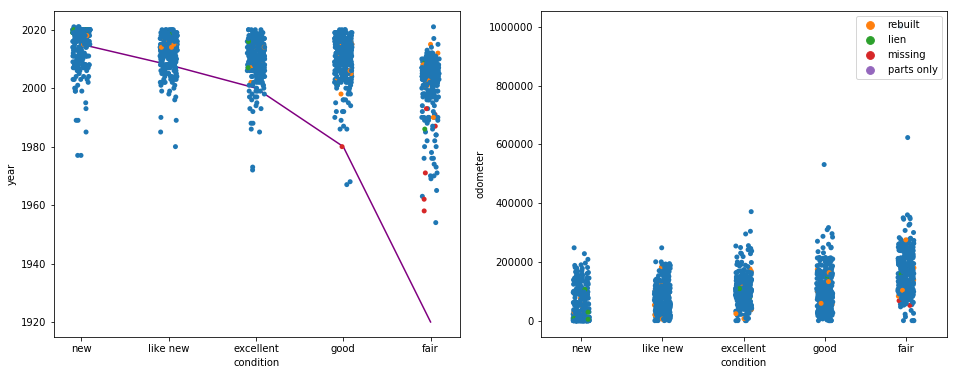

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i, col in enumerate(['year', 'odometer']):
    g = sns.stripplot(
        x='condition',
        y=col,
        hue='title_status',
        hue_order=['clean', 'rebuilt', 'lien', 'missing', 'parts only'],
        data=data \
            .groupby('condition', as_index=False) \
            .apply(lambda x: x.sample(n=data['condition'].value_counts().min()//2)),
        order=['new', 'like new', 'excellent', 'good', 'fair'],
        ax=ax[i]
    )
    if i == 1:
        handles, labels = ax[i].get_legend_handles_labels()
        leg = plt.legend(handles[6:], labels[6:], loc='upper right')
    else:
        ax[i].plot([2015, 2008, 2000, 1980, 1920], c='purple')
        ax[i].get_legend().remove()

plt.show()

In [39]:
def update_condition(condition, year, odometer):
    avg_mileage = 13500
    now = datetime.now().year
    bins = [5, 12, 20, 40, 200]
    if (now - bins[4] <= year < now - bins[3]) & ((now - year)*avg_mileage >= odometer):
        return 'fair'
    elif (now - bins[3] <= year < now - bins[2]) & ((now - year)*avg_mileage >= odometer):
        return 'good'
    elif (now - bins[2] <= year < now - bins[1]) & ((now - year)*avg_mileage >= odometer):
        return 'excellent'
    elif (now - bins[1] <= year < now - bins[0]) & ((now - year)*avg_mileage >= odometer):
        return 'like new'
    elif (year >= now - bins[0]) & ((now - year)*avg_mileage >= odometer):
        return 'new'
    else:
        return condition

In [40]:
data['condition_new'] = data \
    .apply(lambda x: update_condition(x.condition, x.year, x.odometer), axis=1) \
    .fillna('unknown')

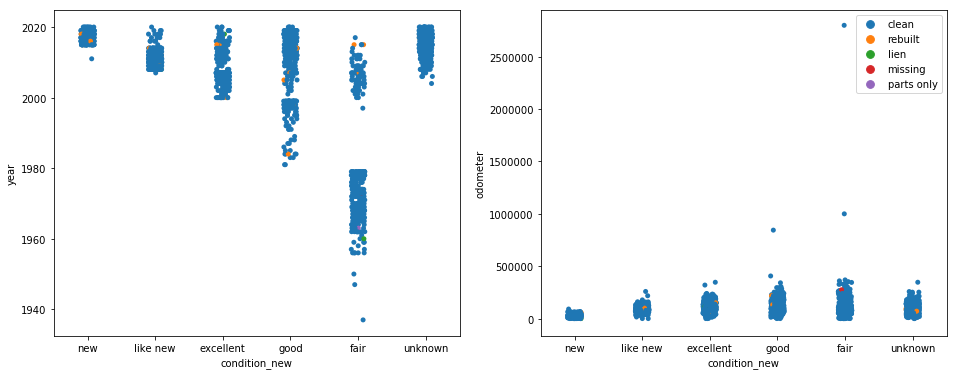

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
for i, col in enumerate(['year', 'odometer']):
    g = sns.stripplot(
        x='condition_new',
        y=col,
        hue='title_status',
        hue_order=['clean', 'rebuilt', 'lien', 'missing', 'parts only'],
        data=data \
            .groupby('condition_new', as_index=False) \
            .apply(lambda x: x.sample(n=data['condition'].value_counts().min()//2)),
        order=['new', 'like new', 'excellent', 'good', 'fair', 'unknown'],
        ax=ax[i]
    )
    if i == 1:
        handles, labels = ax[i].get_legend_handles_labels()
        leg = plt.legend(handles[6:], labels[6:], loc='upper right')
    else:
        ax[i].get_legend().remove()

plt.show()

With the above results, the distribution of the condition over year and odometer seems more realistic. We still have some outliers, and it is not perfect, but the amount have been heavily reduced.

In [42]:
data = data \
    .drop('condition', axis=1) \
    .rename(columns={'condition_new': 'condition'})

In [43]:
data.isna().sum().sort_values(ascending=False) / data.shape[0]

size                   0.692877
engineconfiguration    0.614187
tpms                   0.594650
gvwr                   0.594139
paint_color            0.299468
drive                  0.275502
type                   0.250172
popularity             0.010040
fame                   0.010040
fuel                   0.006993
title_status           0.005242
transmission           0.004259
enginecylinders        0.001006
doors                  0.000951
vin_avg_weight         0.000872
year                   0.000044
description            0.000028
manufacturer           0.000000
odometer               0.000000
condition              0.000000
distance_1             0.000000
state                  0.000000
distance_0             0.000000
distance_2             0.000000
distance               0.000000
model                  0.000000
displacementl          0.000000
enginehp               0.000000
price                  0.000000
dtype: float64

### Size and Color
We simply drop the `size` and `paint_color` columns. The first, because it is roughly 70% missing, and we can gain insight into the size of the vehicles from the `type` column; the latter because the color, in the end, shouldn't affect the value of the car that much.

In [44]:
data = data.drop(['size', 'paint_color'], axis=1)

### Vehicle Type, Fuel, Drive, and Transmission
Being categorical features, it is not possible to fill the missing values with a mean or median value. Instead, we'll try, if possible, to set it to the most frequent value in the `manufacturer` and `model` group.

In [45]:
def fillna_most_frequent(input_data, column, group):
    # Iteratively fills with most frequent by removing group-by member.
    for i in reversed(range(1, len(group))):
        input_data[column] = input_data \
            .groupby(group[:i])[column] \
            .apply(lambda x: x.fillna(x.mode()[0] if len(x.mode()) > 0 else np.nan)) \
            .values
    
    return input_data[column]

In [46]:
data['type'] = fillna_most_frequent(input_data=data, column='type', group=['manufacturer', 'model'])
data['fuel'] = fillna_most_frequent(input_data=data, column='fuel', group=['manufacturer', 'model'])
data['transmission'] = fillna_most_frequent(input_data=data, column='transmission', group=['manufacturer', 'model'])
data['drive'] = fillna_most_frequent(input_data=data, column='drive', group=['manufacturer', 'model'])

### Additional Information from NHTSA
There is a high amount of missing data here, which makes sense, as it comes from a direct join with the `vin` column. However, if we group by `manufacturer` and `model`, in addition with `enginecylinders`, we can try and fill out these values with the most frequent values.

In [47]:
data['engineconfiguration'] = fillna_most_frequent(input_data=data, column='engineconfiguration', group=['manufacturer', 'model', 'enginecylinders'])
data['tpms'] = fillna_most_frequent(input_data=data, column='tpms', group=['manufacturer', 'model', 'enginecylinders'])
data['gvwr'] = fillna_most_frequent(input_data=data, column='gvwr', group=['manufacturer', 'model', 'enginecylinders'])

### Title Status
We'll simply drop rows where `title_status` is missing, as the amount of insight gained vs the time spent correcting would be too little.

In [48]:
data = data.dropna(subset=['title_status'])

In [49]:
data.isna().sum().sort_values(ascending=False) / data.shape[0]

fame                   0.010057
popularity             0.010057
enginecylinders        0.001012
doors                  0.000956
vin_avg_weight         0.000876
engineconfiguration    0.000139
tpms                   0.000139
gvwr                   0.000068
year                   0.000044
description            0.000028
type                   0.000000
fuel                   0.000000
odometer               0.000000
manufacturer           0.000000
title_status           0.000000
transmission           0.000000
drive                  0.000000
condition              0.000000
distance_2             0.000000
state                  0.000000
distance_0             0.000000
distance_1             0.000000
distance               0.000000
model                  0.000000
displacementl          0.000000
enginehp               0.000000
price                  0.000000
dtype: float64

In [50]:
print(f'Rows with missing: {(data.shape[0]-data.dropna().shape[0])/data.shape[0]*100:.2f}%')

Rows with missing: 1.01%


In [51]:
data = data.dropna()

### Description
The `descrition` column could contain additional information about vehicle equipment, which would add value, or damages, which would reduce value. Extracting such information could be done by simply looking for keywords in the text, but since the idea of this model is to end up in a web application, it wouldn't make much sense. A web application should have fields that can be ticked on or off, not a text field, where a person can write whatever she or he wants. 

We could also apply sentiment analysis to assess whether the description field is inherently positive or negative. Since such descriptions would mostly be neutral, this also seems futile. Instead, we'll drop the column to reduce complexity.

In [52]:
data = data.drop('description', axis=1)

### Duplicates
One final note is that we should make sure every row in the dataset is unique to avoid redundancy when splitting the data into train and validation sets. This redundancy would mean, that when shuffling and splitting the data, the model will be testing on part of the training data. We will therefore drop the duplicates from the dataset before saving.

In [53]:
data = data.drop_duplicates()
data.to_parquet('data/vehicles_clean.parquet.gzip', compression='gzip')

## Final Feature Engineering
As a final step of the feature engineering, we need to somehow convert all the categorical features to something numeric. For this, one hot encoding is a usual choice, as it creates additional dummy variables of zeros or ones indicating the label value. For example, converting the following table

| `manufacturer` |
| :- |
| Ford |
| Tesla |
| VW |

with one hot encoding would yield the following result:

| `manufacturer_Ford` || `manufacturer_VW` || `manufacturer_Tesla` |
| --- | --- | --- | --- | --- |
| 1 || 0 || 0 |
| 0 || 0 || 1 |
| 0 || 1 || 0 |

Another choice of handling categorical data would be to use label encoding, which in turn would yield the following from the above input data:

| `manufacturer` |
| :- |
| 1 |
| 2 |
| 3 |

This introduces an issue, however, since the machine learning model would assume, that a Ford is worth less than a Tesla, which in turn is ranked lower than a Volkswagen. It would also imply, if the model is calculating the average internally, that since $\frac{1+3}{2} = 2$, that the average of Ford and Volkswagen is Tesla. This doesn't make sense, which is why we turn to binarization of the data instead. For this, we turn to scikit-learn's OneHotEncoder preprocessor. For the numerical values, we use the PowerTransformer in an attempt to normalize data around the mean, while also scaling it down to a range acceptable for deep learning. We wrap it all up into a pipeline, which we can save for later, when we need to transform never before seen data.

In [54]:
num_cols = data \
    .drop('price', axis=1) \
    .select_dtypes(exclude='object') \
    .columns.values
cat_cols = data \
    .select_dtypes(include='object') \
    .columns.values

pipeline = ColumnTransformer(
    transformers=[
        ('scaler', PowerTransformer(), num_cols),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    sparse_threshold=0
)

In [55]:
X = pipeline.fit_transform(data)

In [56]:
X.shape

(191262, 734)